In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [4]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [5]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [6]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [16]:
def train(epochs, lr):
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        print(f"Epoch {j}: training loss: {loss:.2f}, accuracy: {acc:.1f}")
        
        # checking on the val loss and accuracy once per epoch
        acc, loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        print(f"Validation loss: {loss:.2f}, accuracy: {acc:.1f}")

In [23]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [24]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()

In [26]:
train(5, 0.5)

Epoch 0: training loss: 0.05, accuracy: 98.6
Validation loss: 0.09, accuracy: 97.5
Epoch 1: training loss: 0.04, accuracy: 98.9
Validation loss: 0.08, accuracy: 97.5
Epoch 2: training loss: 0.03, accuracy: 98.9
Validation loss: 0.08, accuracy: 97.7
Epoch 3: training loss: 0.03, accuracy: 99.2
Validation loss: 0.08, accuracy: 97.6
Epoch 4: training loss: 0.02, accuracy: 99.4
Validation loss: 0.08, accuracy: 97.7


In [27]:
train(5, 0.2)

Epoch 0: training loss: 0.01, accuracy: 99.7
Validation loss: 0.07, accuracy: 98.1
Epoch 1: training loss: 0.01, accuracy: 99.7
Validation loss: 0.07, accuracy: 98.0
Epoch 2: training loss: 0.01, accuracy: 99.7
Validation loss: 0.07, accuracy: 98.0
Epoch 3: training loss: 0.01, accuracy: 99.7
Validation loss: 0.08, accuracy: 97.8
Epoch 4: training loss: 0.01, accuracy: 99.8
Validation loss: 0.07, accuracy: 98.0


In [28]:
train(10, 0.01)

Epoch 0: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.1
Epoch 1: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 2: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 3: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 4: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 5: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 6: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 7: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 8: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0
Epoch 9: training loss: 0.01, accuracy: 99.9
Validation loss: 0.07, accuracy: 98.0


In [34]:
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [38]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, Test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.0706, Test accuracy: 97.98%


In [29]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


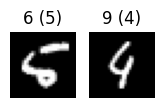

In [39]:
show_failures(nonlinear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Homework: train a Nonlinear Classifier

1. Write some code to train the NonlinearClassifier.
2. Create a data loader for the test data and check your model's accuracy on the test data. 

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

# JupyterHub Reminder

From [Homework 0](https://github.com/argonne-lcf/ai-science-training-series/blob/main/00_introToAlcf/02_jupyterNotebooks.md): "If you simply close your browser window, or logout without shutting down the jupyter server, your job will continue to occupy the worker node. Be considerate and shutdown your job when you finish."

File --> Hub Control Panel --> Stop my server